# DSL Clickstream - Task 1

Solution walktrough for the challenge lab first task.

## Problem Statement

First let's get the source code for the challenge and samples

In [1]:
%%bash
set -e
curl -sSL "https://github.com/GoogleCloudPlatform/specialized-training-content/archive/refs/heads/main.zip" > /tmp/src.zip
rm -rf ./challenge
mkdir -p ./challenge
unzip -q /tmp/src.zip -d ./challenge 'specialized-training-content-main/courses/DSL/*'
rm -f /tmp/src.zip

Now let's open the challenge and get an overall description of the challenge:

/content/challenge/specialized-training-content-main/courses/DSL/challenge-clickstream/challenge-lab.md

Notes from the problem statement:
* Website traffic data is in **Cloud Storage**
* Goals are to move backlog to **Bigquery** and later implement **streamming** and **orchestrate** data pipelines with **CI/CD**
* Data must be **securelly shared across teams** for BI and ML

## Understanding the data

We have sample data in a shared bucket that we must copy to our own.

Before we dive into, let's prepare a "settings" cell. This will help me create "globals" and later extract parameters for the programs that will be created.

This may be updated over the course of the notebook setup and re-run to populate the variables as we go trough.

In [2]:
import os

# Project id defaulting to the configured one for the notebook
project_id = !gcloud config get-value project

# Making settings available to Python
project_id = project_id[0].strip()
raw_data_bucket = f"clickstream-raw-{project_id}"
raw_data_dataset = f"{project_id}.clickstream_raw"

# ... and shell scripts
os.environ['PROJECT'] = project_id
os.environ['RAW_DATA_BUCKET'] = raw_data_bucket
os.environ['RAW_DATA_DATASET'] = raw_data_dataset.replace('.', ':')

Now, let's begin by creating a bucket to hold our staging raw data.

In [3]:
%%bash
# Check if bucket for raw data exists, otherwise create a new one
gcloud storage buckets describe gs://${RAW_DATA_BUCKET} --format='value(name)' 2>/dev/null \
  || gcloud storage buckets create gs://${RAW_DATA_BUCKET}

clickstream-raw-bill-arki1-25-4


Now that we have a bucket, let's copy the sample data to our **rawdata** bucket.

In [4]:
!gcloud storage cp "gs://challenge-lab-data-dar/*" "gs://${RAW_DATA_BUCKET}"

Copying gs://challenge-lab-data-dar/visits-2024-07-01.jsonl to gs://clickstream-raw-bill-arki1-25-4/visits-2024-07-01.jsonl
Copying gs://challenge-lab-data-dar/visits-2024-07-02.jsonl to gs://clickstream-raw-bill-arki1-25-4/visits-2024-07-02.jsonl
Copying gs://challenge-lab-data-dar/visits-2024-07-03.jsonl to gs://clickstream-raw-bill-arki1-25-4/visits-2024-07-03.jsonl
Copying gs://challenge-lab-data-dar/visits-2024-07-04.jsonl to gs://clickstream-raw-bill-arki1-25-4/visits-2024-07-04.jsonl
Copying gs://challenge-lab-data-dar/visits-2024-07-05.jsonl to gs://clickstream-raw-bill-arki1-25-4/visits-2024-07-05.jsonl
Copying gs://challenge-lab-data-dar/visits-2024-07-06.jsonl to gs://clickstream-raw-bill-arki1-25-4/visits-2024-07-06.jsonl
Copying gs://challenge-lab-data-dar/visits-2024-07-07.jsonl to gs://clickstream-raw-bill-arki1-25-4/visits-2024-07-07.jsonl
Copying gs://challenge-lab-data-dar/visits-2024-07-08.jsonl to gs://clickstream-raw-bill-arki1-25-4/visits-2024-07-08.jsonl
Copying 

## Designing the data model

The data is strucutred by a VisitSchema API and houses most of the relevant visit tracking similar to the Google Analytics API.

To better visualize the data, let's first load it 'as is' into Bigquery. This also helps us understand the challenges to query the raw schema and help us design the proper implementation.

In [5]:
%%bash
set -e
if ! bq ls ${RAW_DATA_DATASET} 2>/dev/null ; then
  echo "Creating ${RAW_DATA_DATASET} ..."
  bq mk ${RAW_DATA_DATASET}
fi

# bq load [flags] destination source [schema]
bq load --source_format=NEWLINE_DELIMITED_JSON --autodetect ${RAW_DATA_DATASET}.visits gs://${RAW_DATA_BUCKET}/*.jsonl

  tableId   Type    Labels   Time Partitioning   Clustered Fields  
 --------- ------- -------- ------------------- ------------------ 
  visits    TABLE                                                  


Waiting on bqjob_r3addc31814615853_00000196595c08bb_1 ... (2s) Current status: DONE   


Loading with the auto-detection of schema by Bigquery raises a few possible issues:

* Several fields end up as NULLs
* It becomes a raw 'wide' table and having an improved schema could be beneficial
* The advantage of this flat table is that it does not require JOINs:


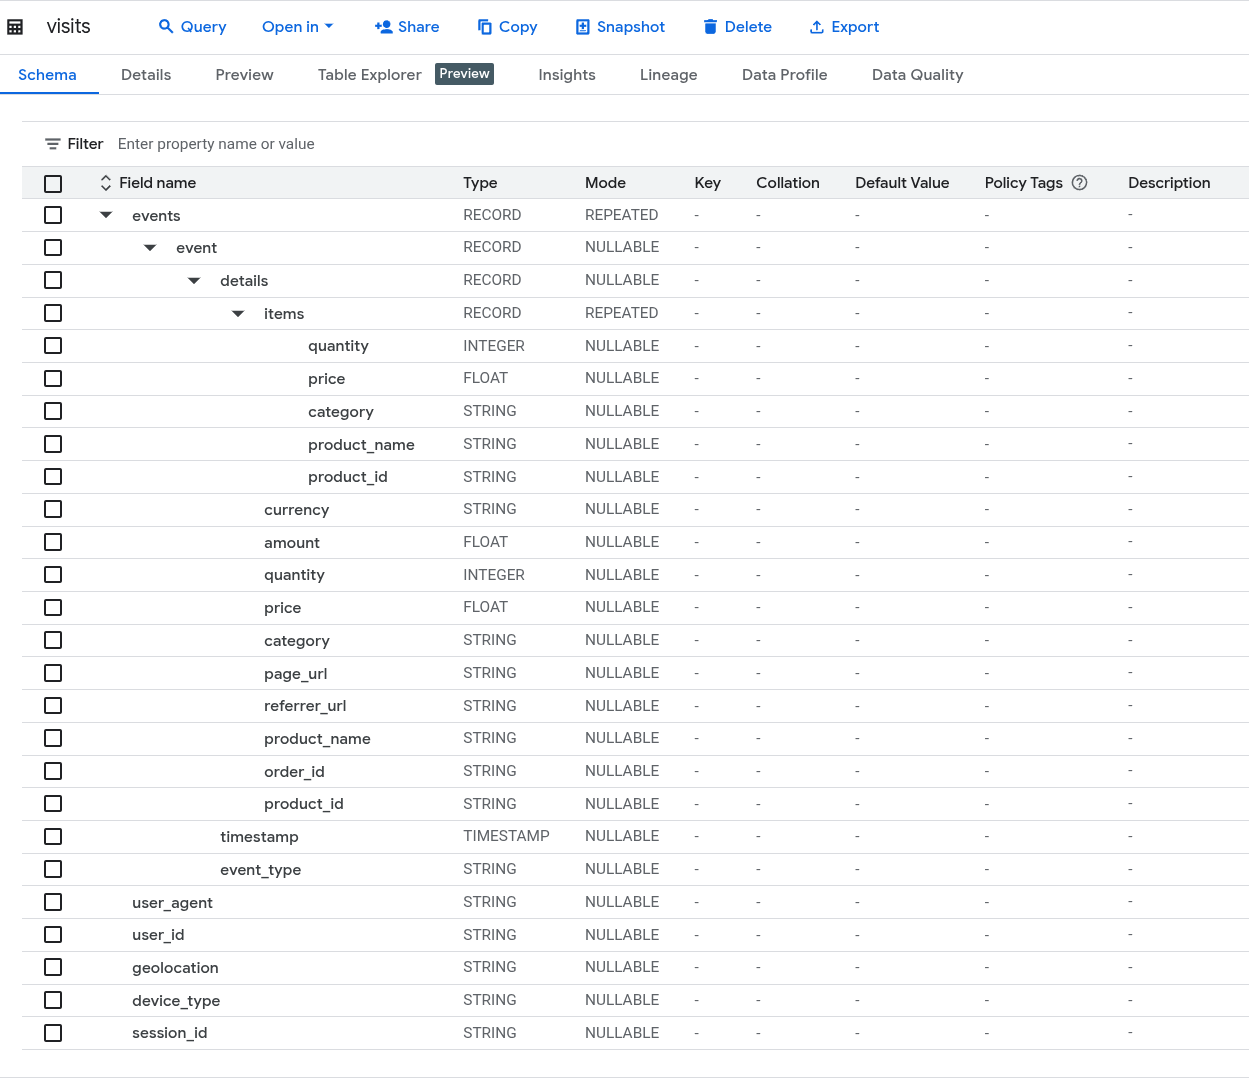

While this table is not useful as is for analysts, it may be useful as is for machine learning folks as it may be useful to retain all data related to a given session to extrapolate some features later on.

So, let's keep this as the raw data in our data lake and create a data wharehouse with a refined version of that schema.

Let's experiment with the schema design first, using the target analysts as a way to explore more easily this data.

In [6]:
%%bigquery
# Query Visits by Page
SELECT
  e.event.details.page_url as url,
  count(*) visits
FROM
  `clickstream_raw.visits` v,
  UNNEST(events) e
WHERE
  e.event.event_type = 'page_view'
GROUP BY e.event.details.page_url
ORDER BY visits DESC

Query is running:   0%|          |

Downloading:   0%|          |

,url,visits
0,https://example.com/cart,64068
1,https://example.com/home,35216
2,https://example.com/products,35216
3,https://example.com/about,3632
4,https://example.com/contact,3556


In [7]:
%%bigquery
# Finding the most Popular Items can lead to confusing with the double-nesting
SELECT
  session_id,
  event.details.product_name as product,
  event.details.items as items
FROM
  `clickstream_raw.visits` v,
  UNNEST(v.events) e
WHERE
  e.event.event_type IN ('add_item_to_cart')
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,session_id,product,items
0,SID-1698,Video Editor Pro,[]
1,SID-1698,Mini PC Cube,[]
2,SID-1698,Ultrabook A400,[]
3,SID-6588,Photo Editor Pro,[]
4,SID-6588,Video Editor Pro,[]
5,SID-7292,"27"" 4K Monitor",[]
6,SID-7292,Laptop X200,[]
7,SID-9560,Office Suite Pro,[]
8,SID-9560,Gaming PC Y900,[]
9,SID-9560,USB-C Docking Station,[]


After some experimentation, one clear problem arises: the nesting field, while good for storage optimizations in Bigquery, causes a burden to the analysts. They need to take into account some nuances of this data layout. **Double nested fields** (events, events.event.items) can result into improper counting. For instance, one could improperly count visits when doing a query that *unnests* the `event.details.items` field; in this case the same visit may be counted as many times there are items in a shopping chart. Also, some queries are extremelly complex to write as all types of events are in the same big table.

More challenges arise if we think about optimizations, such as partitioning by timestamp as well as clustering by session, as some key fields are one or two levels deep in the nesting structure.

I decided to go with the following design, that is a star schema for analytics with the session as facts and each event type as dimensions.

This design takes advantage of the optimized denormalization that Bigquery offers avoiding an extra join when dealing with the purchase_event. This is the only, if any, UNNEST operation needed, but the optimization to avoid two joins makes it an appealing trade-off.

Finally, as an early schema design, let's assume that analysis will happen frequently over a specific time range and for individual users or sessions. Hence, let's partition by timestamp and also cluster by user_id, session_id which could give a reasonable optimization for such queries.

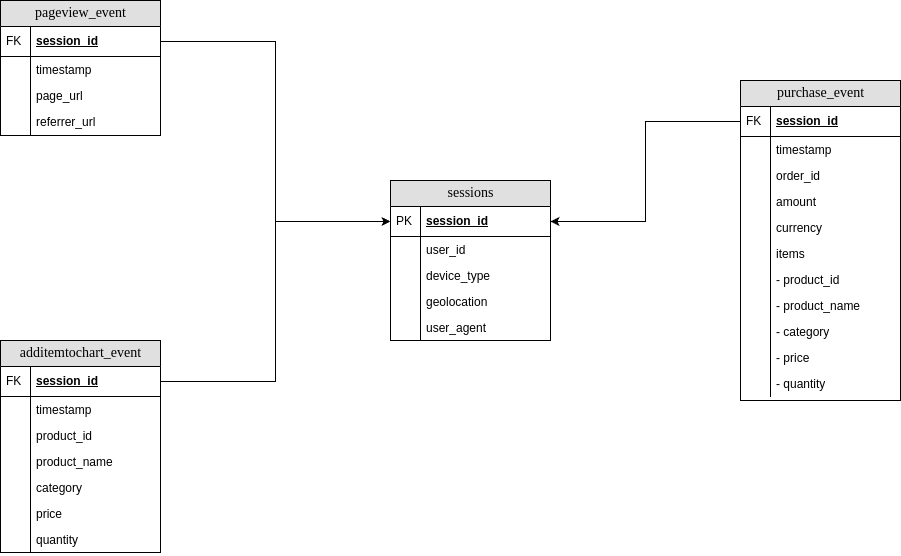

## Developing the ELT code

For this first stage, let's use the ELT aproach and load the raw data into Bigquery, since it is compatible, and later on run some Bigquery jobs to fine tune the schema into the desired one using SQL.

This aproach can be fully automated by a simple script that utilizes the Google Cloud SDK and can be executed virtually anywhere, including an scheduled Cloud Run job.

In [8]:
%%bash
set -e

PROJECT_ID="$(gcloud config get-value project)"

RAW_DATA_BUCKET="clickstream-raw-${PROJECT_ID}"

LAKE_DATASET="${PROJECT_ID}:clickstream_lake"
LAKE_DATASET_FROM="${LAKE_DATASET/:/.}" # Helper variable to run the queries easier
DW_DATASET="${PROJECT_ID}:clickstream_dw"

function log() {
  echo "[INFO] elt-job: $(date '+%Y-%m-%d %H:%M:%S'): $@"
}

log "Building data lake into ${LAKE_DATASET}"
bq ls ${LAKE_DATASET} 2>/dev/null || bq mk ${LAKE_DATASET}
bq load \
  --source_format=NEWLINE_DELIMITED_JSON \
  --replace=true \
  --autodetect=true \
  ${LAKE_DATASET}.visits gs://${RAW_DATA_BUCKET}/*.jsonl

log "Building data wharehouse into ${DW_DATASET}"
bq ls ${DW_DATASET} 2>/dev/null || bq mk ${DW_DATASET}

log "Creating fact table ${DW_DATASET}.sessions ..."
bq query \
  --use_legacy_sql=false \
  --destination_table=${DW_DATASET}.sessions \
  --replace=true \
  --clustering_fields=session_id,user_id \
  --max_rows=0 \
  "SELECT session_id, user_id, device_type, geolocation, user_agent FROM \`${LAKE_DATASET_FROM}.visits\`"

log "Creating fact table ${DW_DATASET}.pageview_events ..."
bq query \
  --use_legacy_sql=false \
  --destination_table=${DW_DATASET}.pageview_events \
  --replace=true \
  --time_partitioning_field=timestamp \
  --time_partitioning_type=MONTH \
  --clustering_fields=session_id \
  --max_rows=0 <<SQL
SELECT
  v.session_id as session_id,
  e.event.timestamp as timestamp,
  e.event.details.page_url as page_url,
  e.event.details.referrer_url as referrer_url
FROM \`${LAKE_DATASET_FROM}.visits\` v,
UNNEST(v.events) e
WHERE e.event.event_type = 'page_view'
SQL

log "Creating fact table ${DW_DATASET}.addtocart_events ..."
bq query \
  --use_legacy_sql=false \
  --destination_table=${DW_DATASET}.addtocart_events \
  --replace=true \
  --time_partitioning_field=timestamp \
  --time_partitioning_type=MONTH \
  --clustering_fields=session_id \
  --max_rows=0 <<SQL
SELECT
  v.session_id as session_id,
  e.event.timestamp as timestamp,
  e.event.details.product_id as product_id,
  e.event.details.product_name as product_name,
  e.event.details.category as category,
  e.event.details.price as price,
  e.event.details.quantity as quantity
FROM \`${LAKE_DATASET_FROM}.visits\` v,
UNNEST(v.events) e
WHERE e.event.event_type = 'add_item_to_cart'
SQL

log "Creating fact table ${DW_DATASET}.purchase_events ..."
bq query \
  --use_legacy_sql=false \
  --destination_table=${DW_DATASET}.purchase_events \
  --replace=true \
  --time_partitioning_field=timestamp \
  --time_partitioning_type=MONTH \
  --clustering_fields=session_id \
  --max_rows=0 <<SQL
SELECT
  v.session_id as session_id,
  e.event.timestamp as timestamp,
  e.event.details.order_id as order_id,
  e.event.details.amount as amount,
  e.event.details.currency as currency,
  e.event.details.items as items
FROM \`${LAKE_DATASET_FROM}.visits\` v,
UNNEST(v.events) e
WHERE e.event.event_type = 'purchase'
SQL

[INFO] elt-job: 2025-04-21 17:18:55: Building data lake into bill-arki1-25-4:clickstream_lake
  tableId   Type    Labels   Time Partitioning   Clustered Fields  
 --------- ------- -------- ------------------- ------------------ 
  visits    TABLE                                                  


Waiting on bqjob_r1d8c430c2c23c1b6_00000196595c3dd0_1 ... (1s) Current status: DONE   


[INFO] elt-job: 2025-04-21 17:19:02: Building data wharehouse into bill-arki1-25-4:clickstream_dw
       tableId        Type    Labels      Time Partitioning        Clustered Fields    
 ------------------- ------- -------- -------------------------- --------------------- 
  addtochart_events   TABLE            MONTH (field: timestamp)   session_id           
  pageview_events     TABLE            MONTH (field: timestamp)   session_id           
  purchase_events     TABLE            MONTH (field: timestamp)   session_id           
  sessions            TABLE                                       session_id, user_id  
[INFO] elt-job: 2025-04-21 17:19:04: Creating fact table bill-arki1-25-4:clickstream_dw.sessions ...


Waiting on bqjob_r7803b7ac331eefa3_00000196595c5828_1 ... (1s) Current status: DONE   


[INFO] elt-job: 2025-04-21 17:19:09: Creating fact table bill-arki1-25-4:clickstream_dw.pageview_events ...


Waiting on bqjob_r1f5d11701747284d_00000196595c6ad1_1 ... (1s) Current status: DONE   


[INFO] elt-job: 2025-04-21 17:19:13: Creating fact table bill-arki1-25-4:clickstream_dw.addtochart_events ...


Waiting on bqjob_r6c2e200e9efb9b0_00000196595c7cd3_1 ... (1s) Current status: DONE   


[INFO] elt-job: 2025-04-21 17:19:18: Creating fact table bill-arki1-25-4:clickstream_dw.purchase_events ...


Waiting on bqjob_r1e1d5ab9e8df892_00000196595c8efa_1 ... (1s) Current status: DONE   


While developing and testing the code, it was useful to re-run entirely to detect possible errors like data duplication (forgot about the --replace flag!).

Visual inspection in the Bigquery Console also helped verify if results were making sense, but a proper data quality may be required.

For instance, by a quick visual inspection we notice some odd data like the order amount possibly with some rounding errors:

```
session_id: SID-1524
amount: 4199.9400000000005
```

Inspecting the order in question we notice that it is comming from a purchase of 6 items with the price of 699.99, and there where indeed some rouding error.

Other data quality issues detected while doing the Dashboard: session_id is unique within a user, but appears to be reused across different users!

Let's fix this obvious error in our query and finish the ELT job:

In [9]:
%%bash
#!/usr/bin/env bash
set -e

# The project ID to load the data is assumed to be the same where the job runs
# Also, the host running the job must provide credentials
PROJECT_ID="$(gcloud config get-value project)"

# The raw data bucket to load data from.
# This is assumed to be the source bucket where events are currently saved
# For the exercise, this is the copy of the exercise provided data
RAW_DATA_BUCKET="clickstream-raw-${PROJECT_ID}"

# The Bigquery data lake with the raw data, with the auto-detected
# schema from Bigquery
LAKE_DATASET="${PROJECT_ID}:clickstream_lake"
# Helper variable to run the queries easier
LAKE_DATASET_FROM="${LAKE_DATASET/:/.}"

# The Bigquery Data Wharehouse where our start schema is loaded
DW_DATASET="${PROJECT_ID}:clickstream_dw"

# Helper function to log with timestamp, useful to inspect the load job itself.
function log() {
  echo "[INFO] elt-job: $(date '+%Y-%m-%d %H:%M:%S'): $@"
}

# Data Lake
log "Building data lake into ${LAKE_DATASET}"
bq ls ${LAKE_DATASET} 2>/dev/null || bq mk ${LAKE_DATASET}
bq load \
  --source_format=NEWLINE_DELIMITED_JSON \
  --replace=true \
  --autodetect=true \
  ${LAKE_DATASET}.visits gs://${RAW_DATA_BUCKET}/*.jsonl

# Data Wharehouse
log "Building data wharehouse into ${DW_DATASET}"
bq ls ${DW_DATASET} 2>/dev/null || bq mk ${DW_DATASET}

log "Creating fact table ${DW_DATASET}.sessions ..."
bq query \
  --use_legacy_sql=false \
  --destination_table=${DW_DATASET}.sessions \
  --replace=true \
  --clustering_fields=session_id,user_id \
  --max_rows=0 \
  "SELECT session_id, user_id, device_type, geolocation, user_agent FROM \`${LAKE_DATASET_FROM}.visits\`"

log "Creating fact table ${DW_DATASET}.pageview_events ..."
bq query \
  --use_legacy_sql=false \
  --destination_table=${DW_DATASET}.pageview_events \
  --replace=true \
  --time_partitioning_field=timestamp \
  --time_partitioning_type=MONTH \
  --clustering_fields=session_id \
  --max_rows=0 <<SQL
SELECT
  v.session_id as session_id,
  v.user_id as user_id,
  e.event.timestamp as timestamp,
  e.event.details.page_url as page_url,
  e.event.details.referrer_url as referrer_url
FROM \`${LAKE_DATASET_FROM}.visits\` v,
UNNEST(v.events) e
WHERE e.event.event_type = 'page_view'
SQL

log "Creating fact table ${DW_DATASET}.addtocart_events ..."
bq query \
  --use_legacy_sql=false \
  --destination_table=${DW_DATASET}.addtocart_events \
  --replace=true \
  --time_partitioning_field=timestamp \
  --time_partitioning_type=MONTH \
  --clustering_fields=session_id \
  --max_rows=0 <<SQL
SELECT
  v.session_id as session_id,
  v.user_id as user_id,
  e.event.timestamp as timestamp,
  e.event.details.product_id as product_id,
  e.event.details.product_name as product_name,
  e.event.details.category as category,
  e.event.details.price as price,
  e.event.details.quantity as quantity
FROM \`${LAKE_DATASET_FROM}.visits\` v,
UNNEST(v.events) e
WHERE e.event.event_type = 'add_item_to_cart'
SQL

log "Creating fact table ${DW_DATASET}.purchase_events ..."
bq query \
  --use_legacy_sql=false \
  --destination_table=${DW_DATASET}.purchase_events \
  --replace=true \
  --time_partitioning_field=timestamp \
  --time_partitioning_type=MONTH \
  --clustering_fields=session_id \
  --max_rows=0 <<SQL
SELECT
  v.session_id as session_id,
  v.user_id as user_id,
  e.event.timestamp as timestamp,
  e.event.details.order_id as order_id,
  ROUND(e.event.details.amount, 2) as amount,
  e.event.details.currency as currency,
  e.event.details.items as items
FROM \`${LAKE_DATASET_FROM}.visits\` v,
UNNEST(v.events) e
WHERE e.event.event_type = 'purchase'
SQL

[INFO] elt-job: 2025-04-21 17:19:23: Building data lake into bill-arki1-25-4:clickstream_lake
  tableId   Type    Labels   Time Partitioning   Clustered Fields  
 --------- ------- -------- ------------------- ------------------ 
  visits    TABLE                                                  


Waiting on bqjob_r170846455f2fbb48_00000196595cab47_1 ... (1s) Current status: DONE   


[INFO] elt-job: 2025-04-21 17:19:30: Building data wharehouse into bill-arki1-25-4:clickstream_dw
       tableId        Type    Labels      Time Partitioning        Clustered Fields    
 ------------------- ------- -------- -------------------------- --------------------- 
  addtochart_events   TABLE            MONTH (field: timestamp)   session_id           
  pageview_events     TABLE            MONTH (field: timestamp)   session_id           
  purchase_events     TABLE            MONTH (field: timestamp)   session_id           
  sessions            TABLE                                       session_id, user_id  
[INFO] elt-job: 2025-04-21 17:19:32: Creating fact table bill-arki1-25-4:clickstream_dw.sessions ...


Waiting on bqjob_r6f62b05d01e2469_00000196595cc5a2_1 ... (1s) Current status: DONE   


[INFO] elt-job: 2025-04-21 17:19:37: Creating fact table bill-arki1-25-4:clickstream_dw.pageview_events ...


Waiting on bqjob_r7d4c43fddce2fdd7_00000196595cd736_1 ... (1s) Current status: DONE   


[INFO] elt-job: 2025-04-21 17:19:41: Creating fact table bill-arki1-25-4:clickstream_dw.addtochart_events ...


Waiting on bqjob_r64a60540efc6f25d_00000196595ce983_1 ... (1s) Current status: DONE   


[INFO] elt-job: 2025-04-21 17:19:46: Creating fact table bill-arki1-25-4:clickstream_dw.purchase_events ...


Waiting on bqjob_r4fc9482fb3466f2e_00000196595cfb8d_1 ... (1s) Current status: DONE   


Note: the sample data generator code has a potential bug. It generates sessions that eventually collide and potentially does not make sense in the input data.

Because the sessions are not generated with a snowflake id or a UUID, they eventually collide across users/devices.

Using the combination of session_id, user_id and device as a surrogate session_key identifier can be used as a remedy to solve the issue.

In [10]:
solution_file="../solutions/task1/elt-job.sh"

In [11]:
%%writefile {solution_file}
#!/usr/bin/env bash
set -e

# The project ID to load the data is assumed to be the same where the job runs
# Also, the host running the job must provide credentials
PROJECT_ID="$(gcloud config get-value project)"

# The raw data bucket to load data from.
# This is assumed to be the source bucket where events are currently saved
# For the exercise, this is the copy of the exercise provided data
RAW_DATA_BUCKET="clickstream-raw-${PROJECT_ID}"

# The Bigquery data lake with the raw data, with the auto-detected
# schema from Bigquery
LAKE_DATASET="${PROJECT_ID}:clickstream_lake"
# Helper variable to run the queries easier
LAKE_DATASET_FROM="${LAKE_DATASET/:/.}"

# The Bigquery Data Wharehouse where our start schema is loaded
DW_DATASET="${PROJECT_ID}:clickstream_dw"

# Helper function to log with timestamp, useful to inspect the load job itself.
function log() {
  echo "[INFO] elt-job: $(date '+%Y-%m-%d %H:%M:%S'): $@"
}

# Data Lake
log "Building data lake into ${LAKE_DATASET}"
bq ls ${LAKE_DATASET} 2>/dev/null || bq mk ${LAKE_DATASET}
bq load \
  --source_format=NEWLINE_DELIMITED_JSON \
  --replace=true \
  --autodetect=true \
  ${LAKE_DATASET}.visits gs://${RAW_DATA_BUCKET}/*.jsonl

# Data Wharehouse
log "Building data wharehouse into ${DW_DATASET}"
bq ls ${DW_DATASET} 2>/dev/null || bq mk ${DW_DATASET}

log "Creating fact table ${DW_DATASET}.sessions ..."
bq query \
  --use_legacy_sql=false \
  --destination_table=${DW_DATASET}.sessions \
  --replace=true \
  --clustering_fields=session_id,user_id \
  --max_rows=0 <<SQL
SELECT
  TO_HEX(SHA1(FORMAT("%s:%s:%s", session_id, user_id, device_type))) as session_key,
  session_id,
  user_id,
  device_type,
  geolocation,
  user_agent
FROM \`${LAKE_DATASET_FROM}.visits\`
SQL

log "Creating fact table ${DW_DATASET}.pageview_events ..."
bq query \
  --use_legacy_sql=false \
  --destination_table=${DW_DATASET}.pageview_events \
  --replace=true \
  --time_partitioning_field=timestamp \
  --time_partitioning_type=MONTH \
  --clustering_fields=session_id \
  --max_rows=0 <<SQL
SELECT
  TO_HEX(SHA1(FORMAT("%s:%s:%s", session_id, user_id, device_type))) as session_key,
  v.session_id as session_id,
  v.user_id as user_id,
  e.event.timestamp as timestamp,
  e.event.details.page_url as page_url,
  e.event.details.referrer_url as referrer_url
FROM \`${LAKE_DATASET_FROM}.visits\` v,
UNNEST(v.events) e
WHERE e.event.event_type = 'page_view'
SQL

log "Creating fact table ${DW_DATASET}.addtocart_events ..."
bq query \
  --use_legacy_sql=false \
  --destination_table=${DW_DATASET}.addtocart_events \
  --replace=true \
  --time_partitioning_field=timestamp \
  --time_partitioning_type=MONTH \
  --clustering_fields=session_id \
  --max_rows=0 <<SQL
SELECT
  TO_HEX(SHA1(FORMAT("%s:%s:%s", session_id, user_id, device_type))) as session_key,
  v.session_id as session_id,
  v.user_id as user_id,
  e.event.timestamp as timestamp,
  e.event.details.product_id as product_id,
  e.event.details.product_name as product_name,
  e.event.details.category as category,
  e.event.details.price as price,
  e.event.details.quantity as quantity
FROM \`${LAKE_DATASET_FROM}.visits\` v,
UNNEST(v.events) e
WHERE e.event.event_type = 'add_item_to_cart'
SQL

log "Creating fact table ${DW_DATASET}.purchase_events ..."
bq query \
  --use_legacy_sql=false \
  --destination_table=${DW_DATASET}.purchase_events \
  --replace=true \
  --time_partitioning_field=timestamp \
  --time_partitioning_type=MONTH \
  --clustering_fields=session_id \
  --max_rows=0 <<SQL
SELECT
  TO_HEX(SHA1(FORMAT("%s:%s:%s", session_id, user_id, device_type))) as session_key,
  v.session_id as session_id,
  v.user_id as user_id,
  e.event.timestamp as timestamp,
  e.event.details.order_id as order_id,
  ROUND(e.event.details.amount, 2) as amount,
  e.event.details.currency as currency,
  e.event.details.items as items
FROM \`${LAKE_DATASET_FROM}.visits\` v,
UNNEST(v.events) e
WHERE e.event.event_type = 'purchase'
SQL

Overwriting ../solutions/task1/elt-job.sh


In [13]:
!bash {solution_file}

[INFO] elt-job: 2025-04-21 17:22:52: Building data lake into bill-arki1-25-4:clickstream_lake
  tableId   Type    Labels   Time Partitioning   Clustered Fields  
 --------- ------- -------- ------------------- ------------------ 
  visits    TABLE                                                  
Waiting on bqjob_r6402e6dc6493725e_00000196595fda70_1 ... (1s) Current status: DONE   
[INFO] elt-job: 2025-04-21 17:22:59: Building data wharehouse into bill-arki1-25-4:clickstream_dw
       tableId        Type    Labels      Time Partitioning        Clustered Fields    
 ------------------- ------- -------- -------------------------- --------------------- 
  addtochart_events   TABLE            MONTH (field: timestamp)   session_id           
  pageview_events     TABLE            MONTH (field: timestamp)   session_id           
  purchase_events     TABLE            MONTH (field: timestamp)   session_id           
  sessions            TABLE                                       session_id,

# Creating the Dashboard

Final dashboard for the sample data was finally properly counting the blended data for the pageviews properly (same total visits by page/by device) after the surrogate unique key.

https://lookerstudio.google.com/reporting/c3e11516-cce4-4fa2-bfa1-6ad31ab6e767


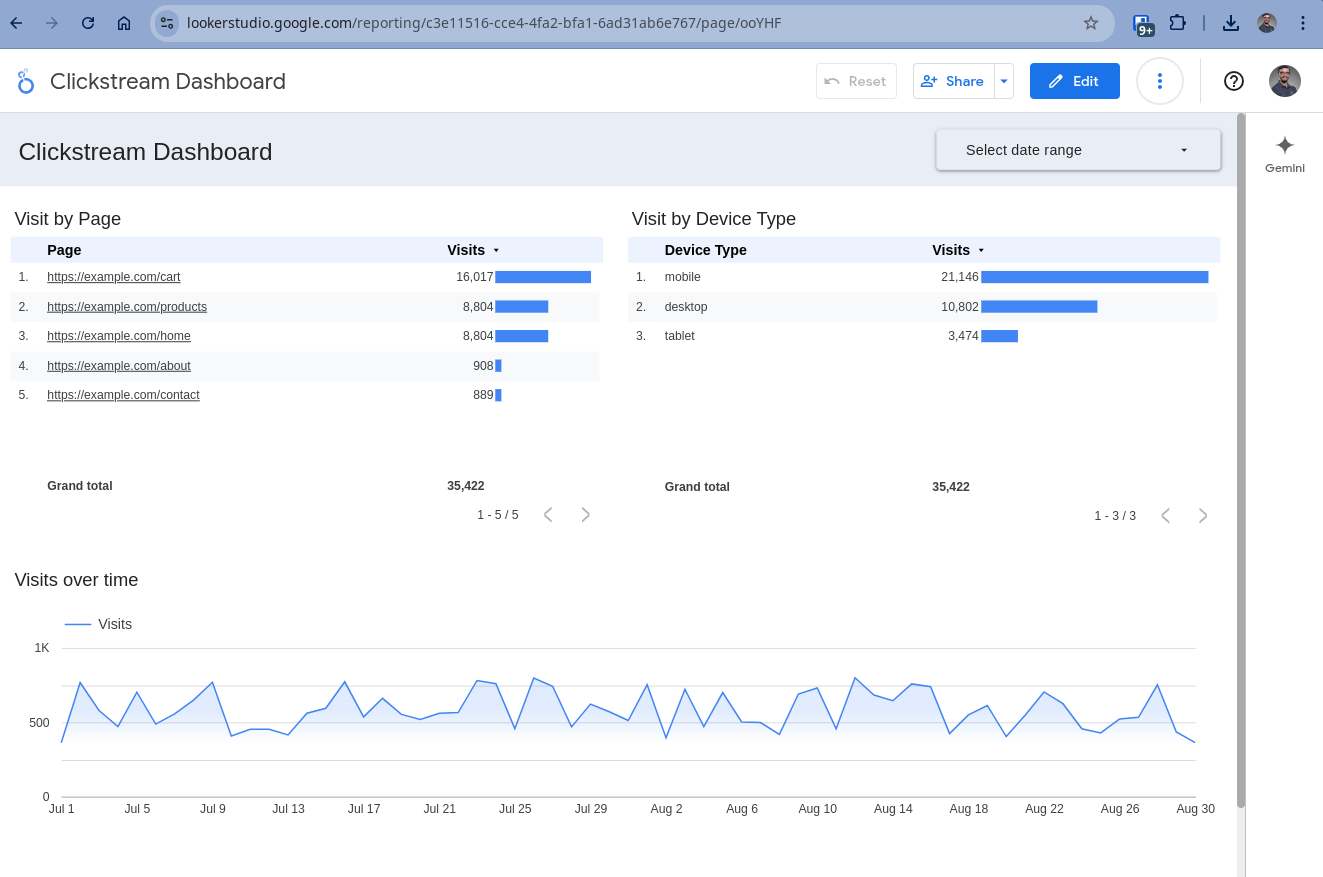

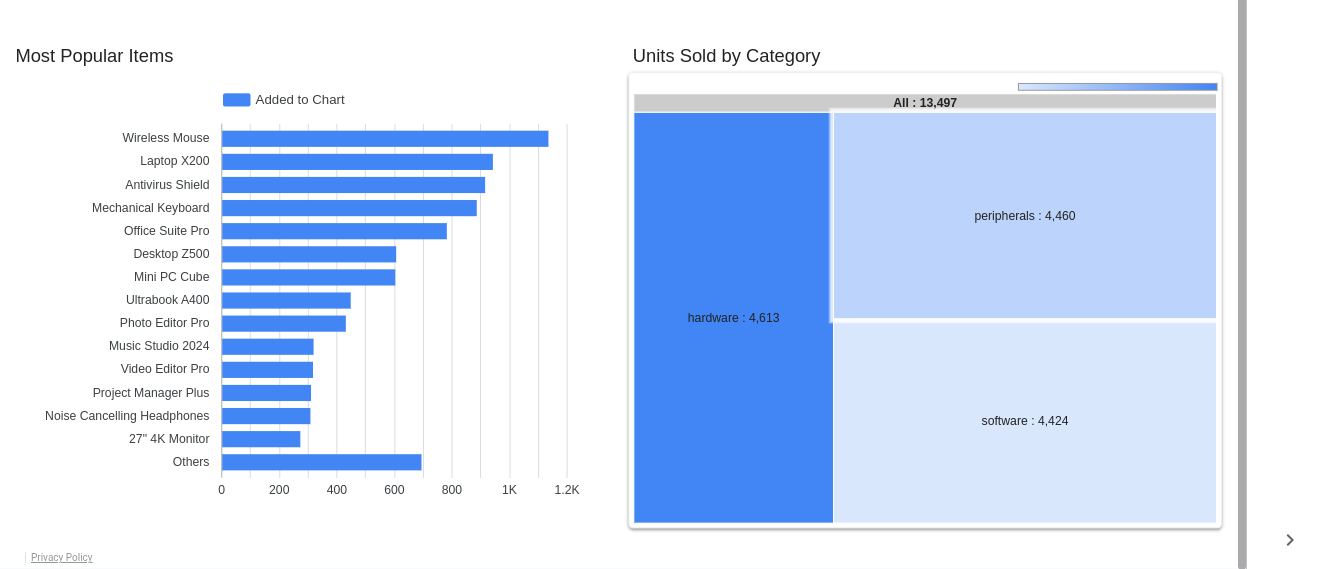

For the dashboard implementation, the charts used where:

* Tables with bars for the visits visualization: makes easy to reason about each and also to compare/validate the total visits
* Bar chart for the top 15 sold items: allows to showcase the "Other" group, also makes easy to compare the sales for the top 15.
* Treemap for the sales by category: shows the volume visually to see wich category is more prominet in net revenue.

While developing the dashboard, we noticed that the.